In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4"

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import corner
import batman
import emcee
import time
from multiprocessing import Pool
from IPython.display import display, Math
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as tck

from exotic_ld import StellarLimbDarkening

import pandas as pd
import pickle

In [2]:
def semi_major_axis_in_stellar_radii(semi_major_axis, R_star):
    """
    Converting the semi-major axis (AU) to (Stellar radii)

    Parameters
    ----------
    semi_major_axis : float
        Semi-major axis of the planet in AU.

    R_star : float
        Stellar radius in R_sun.

    Returns
    -------
    a_stellar_radii : float
        Semi-major axis of the planet in stellar radii.
    """
    #1 AU = 215.032 R_Sun

    a_stellar_radii = semi_major_axis * 215.032 / R_star

    return a_stellar_radii

In [3]:
TIC = 'TIC 181949561' #WASP-39b / TIC 181949561

search_result = lk.search_lightcurve(
    target=TIC,
    mission='TESS', author='SPOC')
print("trying to download")
lc_collection = search_result.download_all()
print("Search done")
print(lc_collection)
lc = lc_collection.stitch(corrector_func=lambda x: x.
                          remove_nans().normalize(unit='unscaled'))

lc = lc.remove_nans()

trying to download
Search done
LightCurveCollection of 1 objects:
    0: <TessLightCurve LABEL="TIC 181949561" SECTOR=51 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>


In [4]:
lc

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2692.9591837111434,1.0026319e+00,2.5027478e-03,5.7287840e-03,1055159,618.38498,866.25181,4.0393496e+03,1.0060067e+01,2.7287864e+03,4.5851231e+00,4.6408438e+03,1.1584373e+01,0,———,———,———,———,618.38498,1.9717452e-03,866.25181,1.9793832e-03,-5.8685638e-02,8.0632448e-02
2692.9605726003288,1.0003240e+00,2.5057544e-03,5.7287849e-03,1055160,618.37992,866.24697,4.0317229e+03,1.0072153e+01,2.7424441e+03,4.5912933e+00,4.6301611e+03,1.1598289e+01,0,———,———,———,———,618.37992,1.9755657e-03,866.24697,1.9882147e-03,-5.8915585e-02,7.4570499e-02
2692.961961489049,1.0007342e+00,2.5062345e-03,5.7287854e-03,1055161,618.38252,866.25050,4.0331528e+03,1.0074082e+01,2.7415742e+03,4.5966668e+00,4.6320601e+03,1.1600512e+01,0,———,———,———,———,618.38252,1.9735647e-03,866.25050,1.9861213e-03,-5.7727616e-02,7.9196885e-02
2692.963350378234,1.0020903e+00,2.5092242e-03,5.7287863e-03,1055162,618.38306,866.25022,4.0376621e+03,1.0086101e+01,2.7576370e+03,4.6068540e+00,4.6383369e+03,1.1614350e+01,0,———,———,———,———,618.38306,1.9762428e-03,866.25022,1.9861609e-03,-6.0848914e-02,8.0616929e-02
2692.9647392669526,9.9770105e-01,2.5077639e-03,5.7287868e-03,1055163,618.38317,866.23965,4.0219282e+03,1.0080231e+01,2.7603035e+03,4.6031342e+00,4.6180205e+03,1.1607591e+01,0,———,———,———,———,618.38317,1.9806640e-03,866.23965,1.9930343e-03,-5.6578293e-02,6.6806413e-02
2692.966128155673,9.9928004e-01,2.5095625e-03,5.7287873e-03,1055164,618.38177,866.24794,4.0263508e+03,1.0087461e+01,2.7621360e+03,4.6097593e+00,4.6253291e+03,1.1615915e+01,0,———,———,———,———,618.38177,1.9833539e-03,866.24794,1.9938273e-03,-5.6851361e-02,8.0369838e-02
2692.967517044858,1.0025119e+00,2.5126385e-03,5.7287882e-03,1055165,618.38355,866.24473,4.0399487e+03,1.0099825e+01,2.7700913e+03,4.6116090e+00,4.6402881e+03,1.1630154e+01,0,———,———,———,———,618.38355,1.9784779e-03,866.24473,1.9910871e-03,-5.9547819e-02,7.5338073e-02
2692.9689059335783,1.0024220e+00,2.5153474e-03,5.7287887e-03,1055166,618.37949,866.25323,4.0393611e+03,1.0110714e+01,2.7775029e+03,4.6197209e+00,4.6398721e+03,1.1642693e+01,0,———,———,———,———,618.37949,1.9808933e-03,866.25323,1.9902526e-03,-6.2744863e-02,8.5587136e-02


In [5]:
t = np.array(lc.time.btjd)
flux_data = np.array(lc.flux)
yerrs = np.array(lc.flux_err)

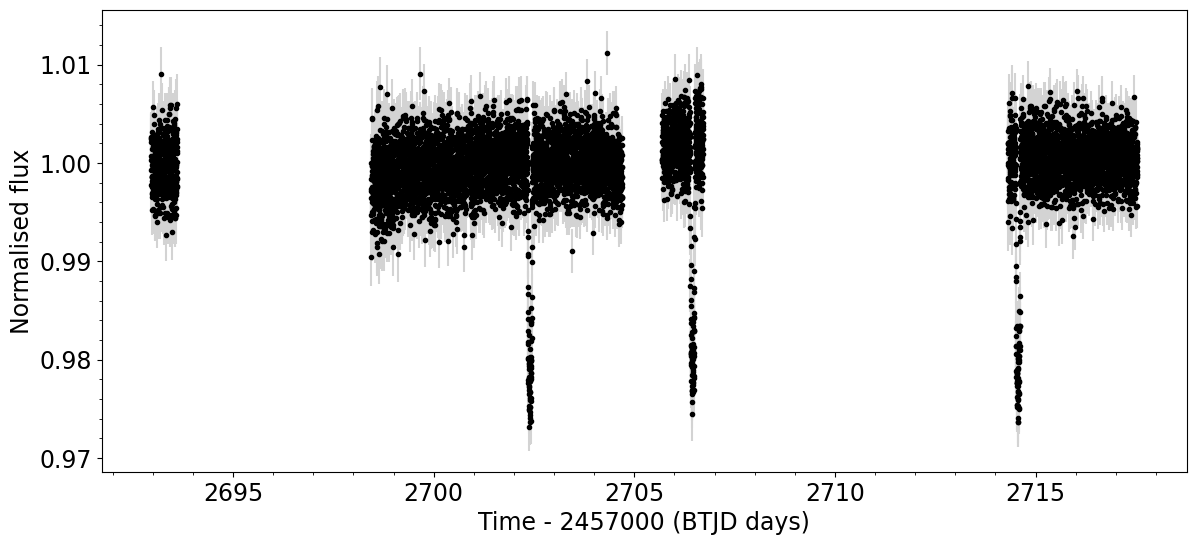

In [6]:
fig, ax = plt.subplots(1, figsize=(14,6))
plt.errorbar(t, flux_data, yerrs, fmt='.', color='Black', ecolor='LightGrey')


plt.ylabel("Normalised flux", size=17)
plt.xlabel("Time - 2457000 (BTJD days)", size=17)

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.show()


In [7]:
prior_Rs = 0.939 #R_sun, Mancini et al. 2018

guess_params = batman.TransitParams()
guess_params.ecc = 0 #Ricci et al. 2015
guess_params.w = 90
guess_params.limb_dark = "quadratic"
guess_params.u = [0.35092681757927346, 0.22991353177818383]

In [8]:
def log_likelihood(prior_params, true_flux, yerrs):
    """
    
    Parameters
    ----------


    Returns
    -------
    
    """
    t_0, R_planet_stellar, orbital_period, orbital_inclination, semi_major_axis = prior_params

    guess_params.t0 = t_0
    guess_params.rp = R_planet_stellar
    guess_params.per = orbital_period
    guess_params.inc = orbital_inclination
    guess_params.a = semi_major_axis
    
    guess_m = batman.TransitModel(guess_params, t)
    guess_flux = guess_m.light_curve(guess_params)

    L1 = -0.5 * np.power((true_flux - guess_flux), 2) / np.power(yerrs, 2) #Sigma
    L2 = -0.5 * np.log(2 * np.pi * yerrs**2) #Sigma
    L3 = np.sum(L1) + np.sum(L2)
    return L3


def log_prior(prior_params):
    """
    
    Parameters
    ----------


    Returns
    -------
    
    """
    t_0, R_planet_stellar, orbital_period, orbital_inclination, semi_major_axis = prior_params

    P = 0.0
    if (t_0 < 2702.0) or (t_0 > 2703.0): #Days
        P += -np.inf
        return -np.inf

    if (R_planet_stellar < 0.130) or (R_planet_stellar > 0.155):
        P += -np.inf
        return P

    if (orbital_period < 3.9) or (orbital_period > 4.1): #Days
        P += -np.inf
        return P

    if (orbital_inclination < 82) or (orbital_inclination > 90): #Degrees
        P += -np.inf
        return -np.inf
    

    if (semi_major_axis < 10) or (semi_major_axis > 15): #AU
        P += -np.inf
        return P

    return P

def log_prob(prior_params, true_flux, yerrs):
    lp = log_prior(prior_params)
    if (np.isinf(lp) == True):
        return -np.inf

    return log_likelihood(prior_params, true_flux, yerrs) + lp

In [9]:
prior_t0 = 2702.3 #Myself
prior_rprs = 0.1457 #Maciejewski et al. 2016
prior_per = 4.05527999 #(Days) Fischer et al. 2016
prior_inc = 87.93 #(Deg) 4.Fischer et al. 2016
prior_a = semi_major_axis_in_stellar_radii(0.04858, prior_Rs) #(AU) Maciejewski et al. 2016
guess = [prior_t0, prior_rprs, prior_per, prior_inc, prior_a]

In [10]:
scatter = 1E-8 #Walker scattering of the parameters

pos = guess + scatter * np.random.randn(20, len(guess))

nwalkers, ndim = pos.shape

filename = "wasp_39b.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

with Pool() as pool:
    start_time = time.time()
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(flux_data, yerrs), a=2)
    sampler.run_mcmc(pos, 30000, progress=True)
    end_time = time.time()
    execution_time = (end_time - start_time)
    print("Start:       {}".format(time.ctime(int(start_time))))
    print("End:         {}".format(time.ctime(int(end_time))))
    print("Time taken:  {:.2f} s".format(execution_time))

100%|██████████| 30000/30000 [12:37<00:00, 39.61it/s]

Start:       Wed Feb  8 06:59:02 2023
End:         Wed Feb  8 07:11:40 2023
Time taken:  757.42 s


In [12]:
tau = sampler.get_autocorr_time()
print(tau)

[179.16659732 109.63622382 115.47143679 191.73020989 187.04930852]


In [13]:
burnin = int(5 * np.max(tau))
thin = int(0.5 * np.min(tau))
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print(flat_samples.shape)

(10740, 5)


In [14]:
filename = "wasp_39b_flat_samples.p"
file = open(filename, "wb")
pickle.dump(flat_samples, file)
file.close()

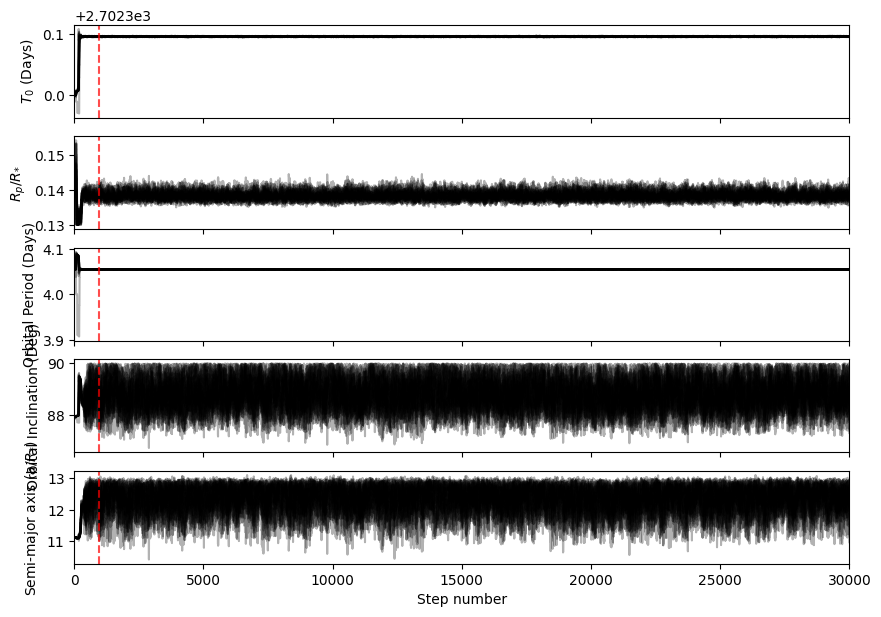

In [15]:
fig, axes = plt.subplots(len(guess), figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$T_{0}$ (Days)", "$R_{p}/R_{*}$", "Orbital Period (Days)", "Orbital Inclination (Deg)", "Semi-major axis ($a/R_{*}$)"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.axvline(x=burnin, color='red', ls="--",alpha=0.7)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("Step number")
plt.show()

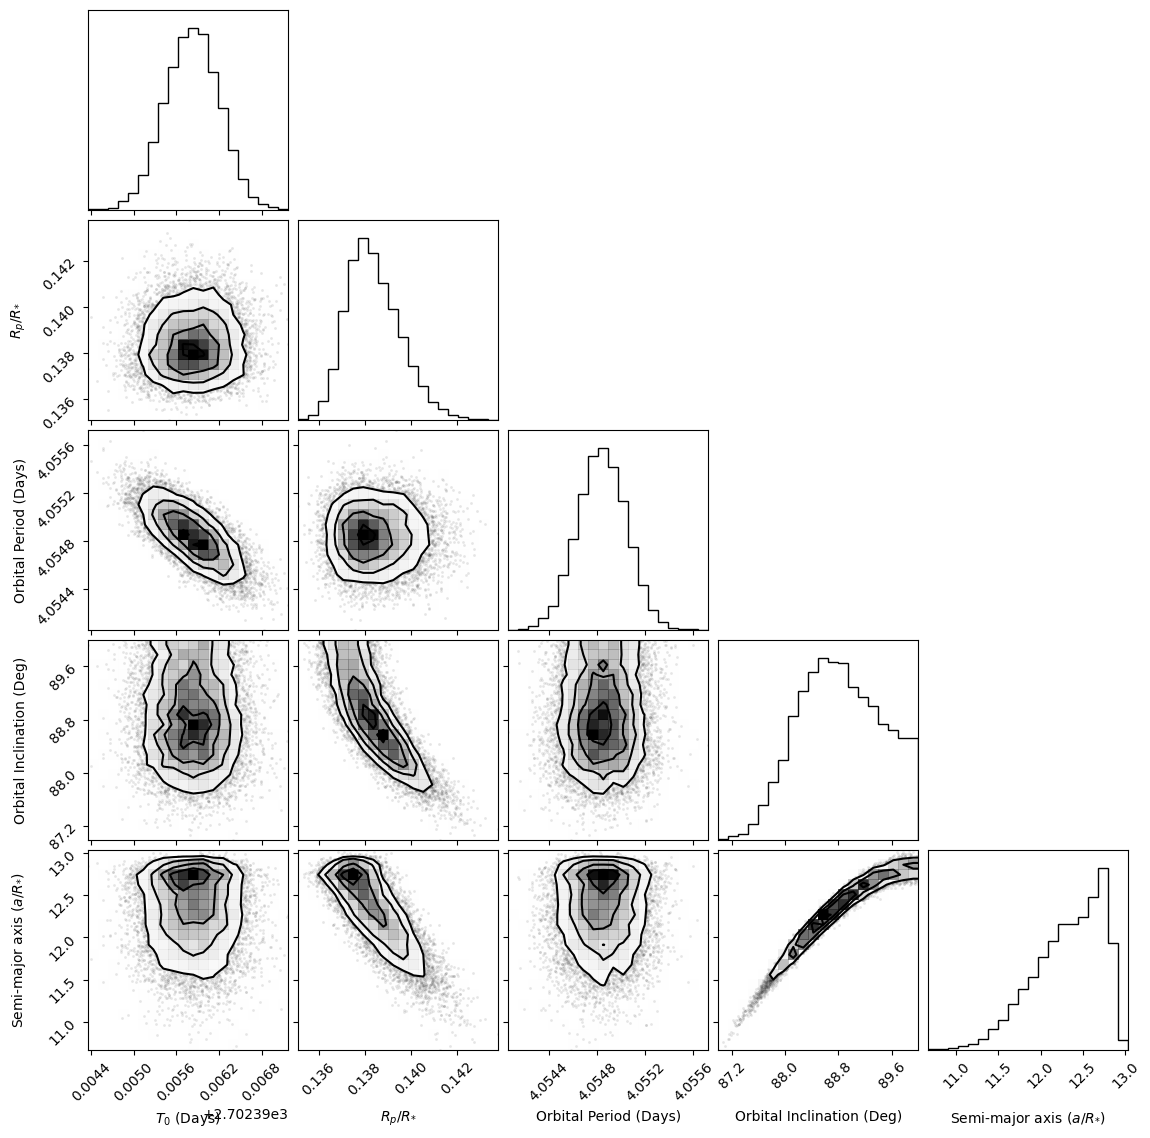

In [16]:
fig = corner.corner(
    flat_samples, labels=labels)

In [17]:
transit_params = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.8f}_{{-{1:.10f}}}^{{{2:.10f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])

    val = "{}+{}-{}".format(mcmc[1], q[0], q[1])
    entry = [labels[i], val]
    transit_params.append(entry)

    display(Math(txt))

df = pd.DataFrame(data=transit_params)

df.to_csv("WASP_39b_params.csv",header=False, index=False)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>